## Kaggle config

In [5]:
!git clone https://github.com/FedeCarollo/PatchTST
%cd ./PatchTST

Cloning into 'PatchTST'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 19 (delta 2), reused 19 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (19/19), 138.03 KiB | 4.45 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [31]:
!unzip archive.zip

Archive:  archive.zip
  inflating: ETTh1.csv               


In [32]:
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
import sys
sys.path.append('./src')

In [34]:
df = pd.read_csv('./archive.zip', index_col=0, sep=',', compression='zip')

In [35]:
!head ETTh1.csv -n 10

date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
2016-07-01 00:00:00,5.827000141143799,2.009000062942505,1.5989999771118164,0.4620000123977661,4.203000068664552,1.3400000333786009,30.5310001373291
2016-07-01 01:00:00,5.692999839782715,2.075999975204468,1.4919999837875366,0.4259999990463257,4.142000198364259,1.371000051498413,27.78700065612793
2016-07-01 02:00:00,5.1570000648498535,1.741000056266785,1.2790000438690186,0.35499998927116394,3.776999950408936,1.218000054359436,27.78700065612793
2016-07-01 03:00:00,5.0900001525878915,1.9420000314712524,1.2790000438690186,0.3910000026226044,3.806999921798706,1.2790000438690186,25.04400062561035
2016-07-01 04:00:00,5.357999801635742,1.9420000314712524,1.4919999837875366,0.4620000123977661,3.868000030517578,1.2790000438690186,21.947999954223643
2016-07-01 05:00:00,5.625999927520752,2.1429998874664307,1.5279999971389768,0.5329999923706055,4.051000118255615,1.371000051498413,21.173999786376953
2016-07-01 06:00:00,7.166999816894531,2.9470000267028813,2.13199

In [36]:
df.head()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
date,,,,,,,
2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


In [37]:
LOOKBACK = 336      # L: Lookback window
HORIZON = 96        # T: Predict next steps
PATCH_DIM = 16      # P: Patch size
STRIDE = 8          # S: Distance between start of subsequent patches
EMBED_DIM = 16      # D: Embedding dimensionality

# As suggested by the paper
NUM_PATCHES = (LOOKBACK - PATCH_DIM) // STRIDE + 2

In [38]:
from src.dataset import ETTh1

train_dataset = ETTh1(file_path='./ETTh1.csv', split='train', lookback=LOOKBACK, horizon=HORIZON)
test_dataset = ETTh1(file_path='./ETTh1.csv', split='test', lookback=LOOKBACK, horizon=HORIZON)
val_dataset = ETTh1(file_path='./ETTh1.csv', split='val', lookback=LOOKBACK, horizon=HORIZON)

In [39]:
sample = train_dataset[0]

sample['input'].shape, sample['target'].shape, sample['mean'], sample['std']

(torch.Size([7, 336]),
 torch.Size([7, 96]),
 tensor([10.4205,  4.1493,  7.0688,  1.9808,  3.2542,  1.5870, 29.7522]),
 tensor([2.6008, 1.3502, 2.2996, 0.9182, 0.7513, 0.3647, 4.9668]))

In [40]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [41]:
import torch

torch.cuda.is_available()

True

In [44]:
from src.patch_tst import PatchTST

model = PatchTST(
    num_patches=NUM_PATCHES, 
    patch_dim=PATCH_DIM, 
    embed_dim=EMBED_DIM, 
    horizon=HORIZON,
    stride=STRIDE)

In [45]:
from torch.optim import Adam

optimizer = Adam(params=model.parameters(), lr=1e-3)

In [58]:
from tqdm import tqdm

EPOCHS = 25
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(DEVICE)
model.train()

for epoch in range(EPOCHS):
    # Training
    model.train()
    train_loss = 0
    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Train]')
    
    for batch in train_pbar:
        input = batch['input'].to(DEVICE)
        target = batch['target'].to(DEVICE)

        pred = model(input)
        loss = torch.nn.functional.mse_loss(pred, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    # Evaluation
    model.eval()
    test_loss = 0
    test_pbar = tqdm(test_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Test]')
    
    with torch.no_grad():
        for batch in test_pbar:
            input = batch['input'].to(DEVICE)
            target = batch['target'].to(DEVICE)

            pred = model(input)
            loss = torch.nn.functional.mse_loss(pred, target)
            test_loss += loss.item()
            test_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_train_loss = train_loss / len(train_loader)
    avg_test_loss = test_loss / len(test_loader)
    print(f'Epoch {epoch+1}/{EPOCHS} - Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}\n')

Epoch 1/25 [Test]: 100%|██████████| 96/96 [00:01<00:00, 62.68it/s, loss=0.5931]


Epoch 1/25 - Train Loss: 0.9237, Test Loss: 0.9059



Epoch 2/25 [Test]: 100%|██████████| 96/96 [00:01<00:00, 64.81it/s, loss=0.8116]


Epoch 2/25 - Train Loss: 0.9052, Test Loss: 0.9192



Epoch 3/25 [Test]: 100%|██████████| 96/96 [00:01<00:00, 65.42it/s, loss=0.9232]


Epoch 3/25 - Train Loss: 0.8754, Test Loss: 0.9758



Epoch 4/25 [Test]: 100%|██████████| 96/96 [00:01<00:00, 64.81it/s, loss=0.7863]


Epoch 4/25 - Train Loss: 0.8509, Test Loss: 0.9348



Epoch 5/25 [Test]: 100%|██████████| 96/96 [00:01<00:00, 63.73it/s, loss=1.4751]


Epoch 5/25 - Train Loss: 0.8310, Test Loss: 1.0670



Epoch 6/25 [Test]: 100%|██████████| 96/96 [00:01<00:00, 65.14it/s, loss=1.4800]


Epoch 6/25 - Train Loss: 0.8109, Test Loss: 1.1281



Epoch 7/25 [Test]: 100%|██████████| 96/96 [00:01<00:00, 63.26it/s, loss=1.5077]


Epoch 7/25 - Train Loss: 0.7820, Test Loss: 1.0948



Epoch 8/25 [Test]: 100%|██████████| 96/96 [00:01<00:00, 64.19it/s, loss=1.2823]


Epoch 8/25 - Train Loss: 0.7599, Test Loss: 1.0277



Epoch 9/25 [Test]: 100%|██████████| 96/96 [00:01<00:00, 64.40it/s, loss=2.1133]


Epoch 9/25 - Train Loss: 0.7395, Test Loss: 1.2221



Epoch 10/25 [Test]: 100%|██████████| 96/96 [00:01<00:00, 62.70it/s, loss=1.5573]


Epoch 10/25 - Train Loss: 0.7132, Test Loss: 1.1138



Epoch 11/25 [Test]: 100%|██████████| 96/96 [00:01<00:00, 64.56it/s, loss=1.6136]


Epoch 11/25 - Train Loss: 0.6864, Test Loss: 1.0879



Epoch 12/25 [Test]: 100%|██████████| 96/96 [00:01<00:00, 64.66it/s, loss=1.6680]


Epoch 12/25 - Train Loss: 0.6675, Test Loss: 1.1520



Epoch 13/25 [Test]: 100%|██████████| 96/96 [00:01<00:00, 64.32it/s, loss=1.6581]


Epoch 13/25 - Train Loss: 0.6496, Test Loss: 1.0873



Epoch 14/25 [Test]: 100%|██████████| 96/96 [00:01<00:00, 64.98it/s, loss=1.1650]


Epoch 14/25 - Train Loss: 0.6314, Test Loss: 1.0377



Epoch 15/25 [Test]: 100%|██████████| 96/96 [00:01<00:00, 62.65it/s, loss=2.2809]


Epoch 15/25 - Train Loss: 0.6114, Test Loss: 1.1063



Epoch 16/25 [Test]: 100%|██████████| 96/96 [00:01<00:00, 63.98it/s, loss=1.3039]


Epoch 16/25 - Train Loss: 0.6005, Test Loss: 1.0480



Epoch 17/25 [Test]: 100%|██████████| 96/96 [00:01<00:00, 64.25it/s, loss=1.9867]


Epoch 17/25 - Train Loss: 0.5842, Test Loss: 1.1429



Epoch 18/25 [Test]: 100%|██████████| 96/96 [00:01<00:00, 65.06it/s, loss=1.5268]


Epoch 18/25 - Train Loss: 0.5675, Test Loss: 1.1279



Epoch 19/25 [Test]: 100%|██████████| 96/96 [00:01<00:00, 63.21it/s, loss=1.7446]


Epoch 19/25 - Train Loss: 0.5585, Test Loss: 1.1087



Epoch 20/25 [Test]: 100%|██████████| 96/96 [00:01<00:00, 65.22it/s, loss=2.0422]


Epoch 20/25 - Train Loss: 0.5437, Test Loss: 1.1062



Epoch 21/25 [Test]: 100%|██████████| 96/96 [00:01<00:00, 65.19it/s, loss=1.6097]


Epoch 21/25 - Train Loss: 0.5374, Test Loss: 1.1192



Epoch 22/25 [Test]: 100%|██████████| 96/96 [00:01<00:00, 63.56it/s, loss=2.5501]


Epoch 22/25 - Train Loss: 0.5243, Test Loss: 1.2398



Epoch 23/25 [Test]: 100%|██████████| 96/96 [00:01<00:00, 63.30it/s, loss=2.9758]


Epoch 23/25 - Train Loss: 0.5143, Test Loss: 1.2252



Epoch 24/25 [Test]: 100%|██████████| 96/96 [00:01<00:00, 65.38it/s, loss=1.6691]


Epoch 24/25 - Train Loss: 0.5046, Test Loss: 1.0961



Epoch 25/25 [Test]: 100%|██████████| 96/96 [00:01<00:00, 64.81it/s, loss=1.0189]

Epoch 25/25 - Train Loss: 0.4969, Test Loss: 1.0473



In [59]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
val_loss = 0
for batch in val_loader:
    input = batch['input'].to(DEVICE)
    target = batch['target'].to(DEVICE)

    mean = batch['mean'].to(DEVICE)
    std = batch['std'].to(DEVICE)

    pred = model(input)
    
    # Add dimension for broadcasting: (batch, features) -> (batch, features, 1)
    pred = pred * std.unsqueeze(-1) + mean.unsqueeze(-1)
    target = target * std.unsqueeze(-1) + mean.unsqueeze(-1)

    loss = torch.nn.functional.mse_loss(pred, target)
    val_loss += loss.item()
    print(f'Validation Loss: {loss.item():.4f}\r')

avg_val_loss = val_loss / len(val_loader)
print(f'Average Validation Loss: {avg_val_loss:.4f}')



Validation Loss: 5.5571
Validation Loss: 5.1202
Validation Loss: 4.2514
Validation Loss: 6.4501
Validation Loss: 13.5345
Validation Loss: 15.7506
Validation Loss: 10.4739
Validation Loss: 7.0584
Validation Loss: 9.3126
Validation Loss: 9.1444
Validation Loss: 7.0895
Validation Loss: 5.9630
Validation Loss: 4.8397
Validation Loss: 3.8250
Validation Loss: 4.0770
Validation Loss: 8.3374
Validation Loss: 12.4165
Validation Loss: 14.6060
Validation Loss: 11.2304
Validation Loss: 9.9175
Validation Loss: 12.0665
Validation Loss: 14.0313
Validation Loss: 11.2132
Validation Loss: 9.2677
Validation Loss: 14.4437
Validation Loss: 23.6750
Validation Loss: 19.0306
Validation Loss: 9.7198
Validation Loss: 7.7173
Validation Loss: 10.0103
Validation Loss: 10.4510
Validation Loss: 14.8696
Validation Loss: 10.4155
Validation Loss: 9.0684
Validation Loss: 8.7088
Validation Loss: 12.5612
Validation Loss: 21.6714
Validation Loss: 22.2418
Validation Loss: 16.7034
Validation Loss: 8.9305
Validation Loss: 4.9

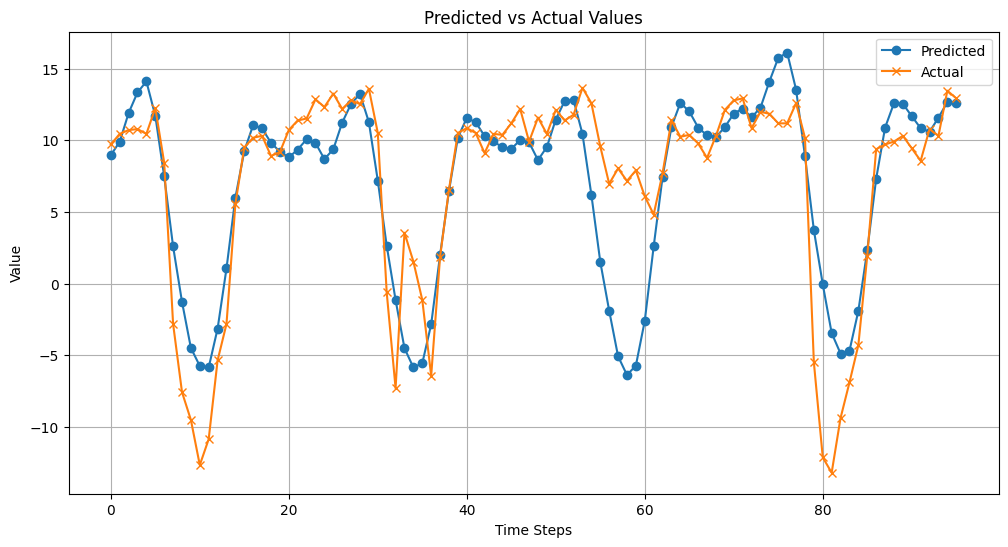

In [60]:
idx = 0
feature_idx = 0

model.eval()

input = val_dataset[idx]['input'].unsqueeze(0).to(DEVICE)
target = val_dataset[idx]['target'].unsqueeze(0).to(DEVICE)
with torch.no_grad():
    pred = model(input)

mean = val_dataset[idx]['mean'].to(DEVICE).unsqueeze(-1)
std = val_dataset[idx]['std'].to(DEVICE).unsqueeze(-1)

pred = pred * std + mean
target = target * std + mean

pred = pred.cpu().squeeze().numpy()
target = target.cpu().squeeze().numpy()

plt.figure(figsize=(12, 6))
plt.plot(pred[feature_idx], label='Predicted', marker='o')
plt.plot(target[feature_idx], label='Actual', marker='x')
plt.title('Predicted vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

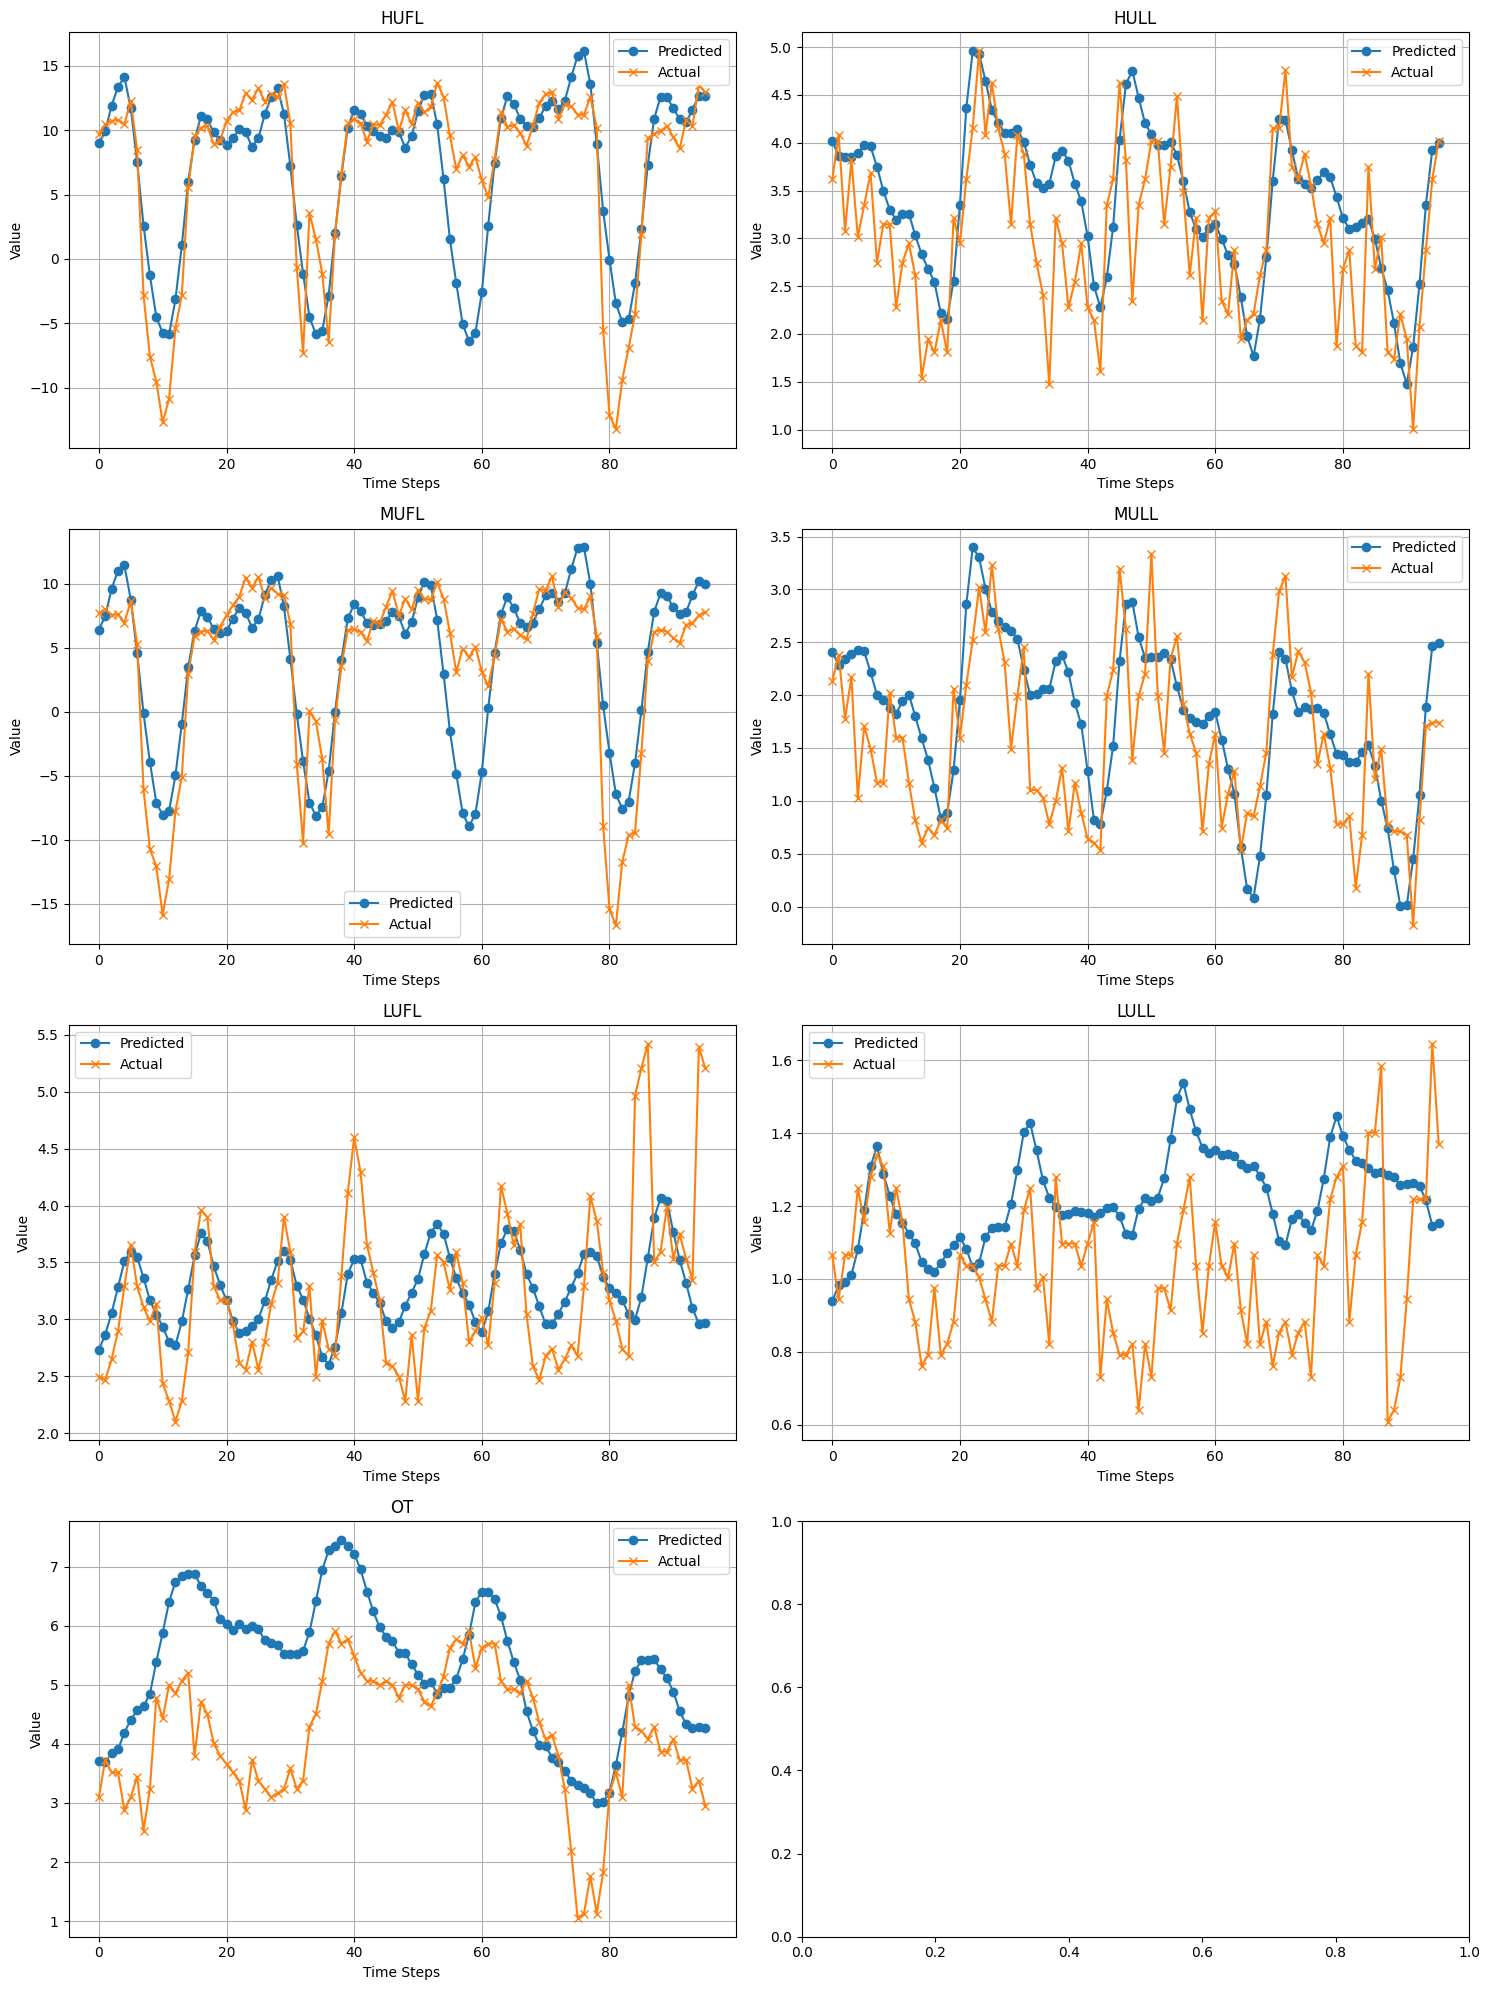

In [65]:
plt.subplots(4, 2, figsize=(15, 20))
features = "HUFL,HULL,MUFL,MULL,LUFL,LULL,OT".split(",")
for feature_idx in range(pred.shape[0]):
    plt.subplot(4, 2, feature_idx + 1)
    plt.plot(pred[feature_idx], label='Predicted', marker='o')
    plt.plot(target[feature_idx], label='Actual', marker='x')
    plt.title(f'{features[feature_idx]}')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.grid()
plt.tight_layout()
plt.savefig("predictions.jpg")
plt.show()